# A simple example, solved two ways

1. QSS
2. CVXPY w/ defaults (fails gracefully, nonconvex)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
from time import time
import seaborn as sns
import cvxpy as cvx
sns.set_style('darkgrid')
import sys
sys.path.append('/Users/bennetmeyers/Documents/Boyd-work/optimal-signal-demixing/')

In [3]:
from gfosd import Problem 
from gfosd.components import *

## Data generation

In [4]:
np.random.seed(42)
t = np.linspace(0, 1000, 200)
signal1 = np.sin(2 * np.pi * t * 1 / (500.))
signal2 = signal.square(2 * np.pi * t * 1 / (450.))
X_real = np.zeros((3, len(t)), dtype=float)
X_real[0] = 0.15 * np.random.randn(len(signal1))
X_real[1] = signal1
X_real[2] = signal2
y = np.sum(X_real, axis=0)
K, T = X_real.shape

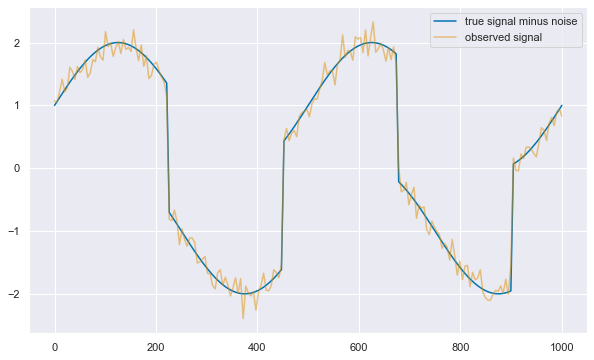

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(t, np.sum(X_real[1:], axis=0), label='true signal minus noise')
plt.plot(t, y, alpha=0.5, label='observed signal')
plt.legend()
plt.show()

# Problem definition

In [6]:
c1 = SumSquare(weight=1/T)
c2 = Aggregate([
    SumSquare(weight=1e3/T, diff=2),
#     Periodic(T=len(y), period=500)
])
c3 = Aggregate([
    SumAbs(weight=1e0/T, diff=1),
    Inequality(vmax=1, vmin=-1),
    
])


components = [c1, c2, c3]

problem = Problem(y, components)

## Solve with QSS, using defaults

In [7]:
problem.decompose(verbose=True)
print('\nobjective value: {:.4e}'.format(problem.objective_value))

---------------------------------------------------------------
              QSS: the Quadratic-Separable Solver              
                     author: Luke Volpatti                     
---------------------------------------------------------------

### Preconditioning finished in 0.010377883911132812 seconds. ###
### Factorization finished in 0.005156755447387695 seconds. ###
 #####     Beginning ADMM solve     #####
---------------------------------------------------------------
 iter | objective | primal res | dual res |   rho   | time (s) 
---------------------------------------------------------------
    1 | 1.43e-01    8.77e-01     1.05e-01   1.00e-01  1.30e-03
   25 | 4.68e-02    1.64e-02     8.89e-04   1.00e-01  1.03e-02
   50 | 4.79e-02    3.75e-03     1.11e-03   1.00e-01  1.87e-02
   75 | 4.80e-02    7.33e-03     8.87e-04   1.00e-01  2.77e-02
  100 | 4.77e-02    6.21e-03     4.54e-04   1.00e-01  3.69e-02
  125 | 4.75e-02    2.76e-03     4.96e-04   1.00e-01  4.59e-02
 

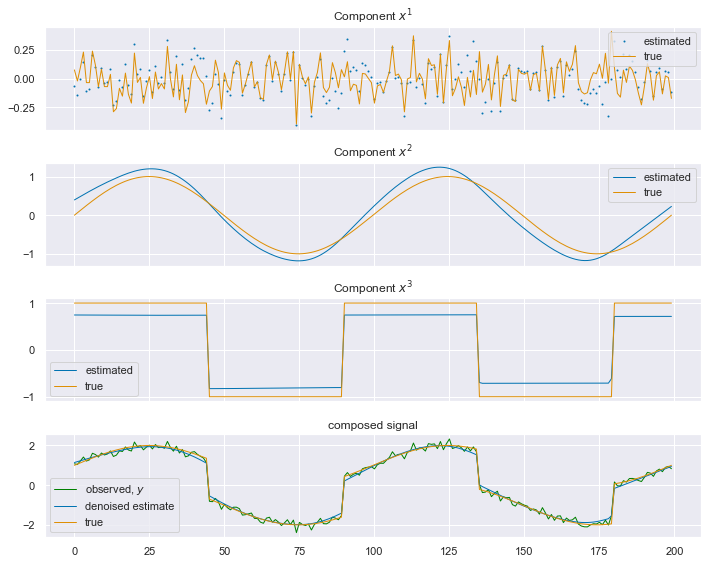

In [8]:
problem.plot_decomposition(X_real=X_real);

## Solve with CVXPY, letting CVXPY choose the solver

This is equivalent to `problem.solve(solver=None)`

In [9]:
problem.decompose(solver='cvx', verbose=True)
print('\nobjective value: {:.4e}'.format(problem.objective_value))

                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Jul 18 04:12:21 PM: Your problem has 997 variables, 3 constraints, and 0 parameters.
(CVXPY) Jul 18 04:12:21 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 18 04:12:21 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 18 04:12:21 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 18 04:12:21 PM: Compiling problem (target solver=OSQP).
(CVXPY) Jul 18 04:12:21 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffin

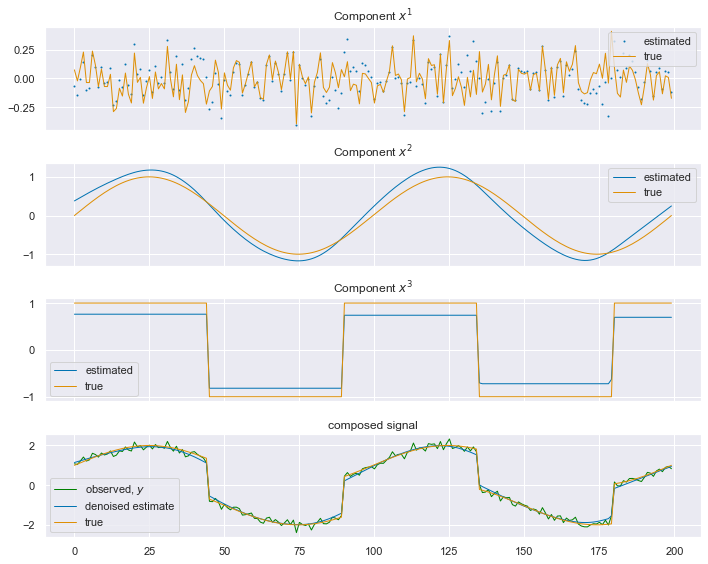

In [10]:
problem.plot_decomposition(X_real=X_real);